# 6. Static Optimization

## 6.1. Objectives

**Introduction**

Static Optimization is a method for estimating muscle activations and muscle forces that satisfy the positions, velocities, accelerations, and external forces (e.g., ground reaction forces) of a motion. The technique is called  "static" since calculations are performed at each time frame, without integrating the equations of motion between time steps. Static Optimization can be very fast and efficient because there is no integration, but it does ignore activation dynamics and tendon compliance. See [[1]](https://doi.org/10.1115/1.4029304) for more details regarding this and similar modeling and simulation choices and their pros and cons.


**Purpose**

In this tutorial, you will learn how to perform a Static Optimization analysis on a single stride gait trial and assess gastrocnemius activation and force production in a simplified example model ([gait10dof18musc](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Musculoskeletal+Models)).

As with any analysis or simulation, the Static Optimization results' quality largely depends on the quality of the model, motion, and forces used as inputs. The model should have mass, anthropometry, and strength that represent the experimental participant; while the degrees of freedom and muscle geometry should be appropriate for the questions being asked (e.g., studying an upper body motion would require a more detailed upper extremity muscle set and skeletal geometry). The motion should contain smooth, realistic accelerations and all external forces during the motion (e.g., ground reaction forces) should be accurately measured and applied to the model. Additional forces (i.e., reserves and residuals) are often needed but should be small enough to not confound analysis. Any issues with your inputs will give you poor results or cause the tool to fail.

In this tutorial, you will:

*   Get an initial Static Optimization analysis running without error messages or crashes.
*   Improve the activation and force results by using improved motion data.
*   Learn how to reduce actuation from reserve and residual actuators.
*   Add passive forces and observe their effect on muscle activation.


**Format**

Each section of the tutorial guides you through certain tools within OpenSim and asks you to answer a few questions. The questions can be answered based on information from OpenSim and basic knowledge of the human musculoskeletal system. As you complete each section of the tutorial, feel free to explore OpenSim and the lower extremity model further on your own.


**Before You Get Started**

This tutorial begins in a workflow where the model is scaled, Inverse Kinematics run, and Residual Reduction Analysis performed.

Before completing the tutorial, make sure you have reviewed the following reading from the User's Guide and completed the prerequisite tutorials.

User Guide | Prerequisite Tutorials | Other Resources
--------------------|------------------------|------------------
[Static Optimization](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Static+Optimization) | [Tutorial 1: Set up OpenSim in Google Colab](https://drive.google.com/file/d/1P_2IRJFzdodS1-ce4BsOsC9d8xWXCqXS/view?usp=sharing)          | [[1]](https://doi.org/10.1115/1.4029304)  
[Inverse Kinematics](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Inverse+Kinematics)  | [Tutorial 2 : Creating and Simulating a simple arm Model ](https://drive.google.com/file/d/1xCa4jvEfey1rO5QDmwtBcJ7zaw1N7JH5/view?usp=sharing)         | [[2]](https://doi.org/10.1109/TBME.2007.901024)  
[Residual Reduction Algorithm](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Residual+Reduction+Algorithm)  | [Tutorial 3: Load Save Models and Accessing Modifying Data](https://drive.google.com/file/d/19pDZuwY_mB6-E6GYBpvElIsTDYsPvHWp/view?usp=sharing)        |               
[Inverse Dynamics](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Inverse+Dynamics)  | [Tutorial 4: Musculoskeletal models, Motion Files and MuscleAnalysis](https://drive.google.com/file/d/15mCynLzgpgfzNId2oFAZHn35AquDFVLS/view?usp=sharing)           |            
                         | [Tutorial 5: Scaling, Inverse Kinematics and Inverse Dynamics](https://drive.google.com/file/d/1LdU0egYKfMyqzijZtb7iN8u-7E8AUKhG/view?usp=sharing)           |                    

**Resources**

All of the files necessary to complete this tutorial are available in the following Google Drive folder: https://drive.google.com/drive/folders/1kfs8YjVJG1fqD6Lzoaoo3jZPMPz4DbaD?usp=sharing

While you complete the tutorial, you will find cells that automatically download the required files.

To obtain a link to one of the files in Google Drive, right-click over it and click on **Get Link**.

## 6.2. Setup Conda and OpenSim

First, set up the environment by executing the following cell (See [Tutorial 1: Introduction to OpenSim in Colab](https://drive.google.com/file/d/1P_2IRJFzdodS1-ce4BsOsC9d8xWXCqXS/view?usp=sharing) for more information).

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

Don't worry if after executing the previous cell you get an error saying that your session has failed. The reason for this is that condacolab needs to restart the session for the changes to take effect. Because of this, you have to execute the previous cell first, before executing any other cell.

Now, let's install the OpenSim conda package.

In [2]:
# !conda install -c opensim-org opensim

## 6.3. Study 1: Run Static Optimization

###6.3.1. Static Optimization is failing.

The objective of this study is to perform Static Optimization over the `gait10dof18musc` model, using results from IK as motion and a set of external forces applied to it. You don't have to worry about calculating the IK results and the external forces, since you will download them in the next subsection. Once Static Optimization has been calculated, we want to visualize the activation of the gastrocnemius muscle.



**Printing OpenSim logs**

To visualize OpenSim's log information, we need to redirect it to either the console, or a file. In this case, we are going to do both.

To output OpenSim's log information to the console, we need to create a [LogSink](https://simtk.org/api_docs/opensim/api_docs/classOpenSim_1_1LogSink.html). A `LogSink` is an object that is able to report logging messages.  We want the log messages to appear as python output, so we implement the class in a way that every message is printed, and we add the sink to OpenSim's [Logger](https://simtk.org/api_docs/opensim/api_docs/classOpenSim_1_1Logger.html).

To output OpenSim's log information to a file, we just need to call the function addSinkFile(), passing as an argument a name for the log file.

In [3]:
import opensim as osim

class PythonOutputSink(osim.common.LogSink):
    def __init__(self):
      super().__init__()
      self.msg = ""

    def flushImpl(self):
      self.msg = ""

    def sinkImpl(self, str):
      self.msg += str + "\n";
      print(self.msg)

python_output_sink = PythonOutputSink()

osim.Logger.addSink(python_output_sink)
osim.Logger.addFileSink("opensim-log.log")


**Download the files**

First, let's download the model (`gait10dof18musc_simbody.osim`), the IK results (`subject01_walk_IK.mot`) and the external forces (`subject01_walk_grf.xml` and `subject01_walk_grf.mot`) files. The files are stored in a Google Drive folder (See **Resources** in the Objectives section).

In [4]:
# !gdown "1EqkSbNdd22cAWmeQmIaa9xcrHmQ0D8xb&confirm=t" # gait10dof18musc_simbody.osim
# !gdown "1-MLmlc5KWPjqYJNKhay7og5N98Ysq42R&confirm=t" # subject01_walk_IK.mot
# !gdown "1EmIfMeZTrkGkqMLNQqE7HitAKFZu8OwL&confirm=t" # subject01_walk_grf.xml
# !gdown "113N5nsy-Sn_6VYuUFsVE7regFe9OOJOH&confirm=t" # subject01_walk_grf.mot

Load the model into OpenSim. To check that the file has been downloaded correctly, let's print its name. Notice that we are getting more information printed to the console because of the Python `LogSink` that we've added. You can also see the logs in the `opensim-log.log` file that has been created.

In [6]:
# Load the model.
gait1018 = osim.Model('gait10dof18musc_simbody.osim')
print("Name of the model:", gait1018.getName())

Updating Model file from 30000 to latest format...

Loaded model Scaled_Model from file gait10dof18musc_simbody.osim

Couldn't find file 'sacrum.vtp'.

Couldn't find file 'pelvis.vtp'.

Couldn't find file 'l_pelvis.vtp'.

Couldn't find file 'femur_r.vtp'.

Couldn't find file 'tibia_r.vtp'.

Couldn't find file 'fibula.vtp'.

Couldn't find file 'talus.vtp'.

Couldn't find file 'foot.vtp'.

Couldn't find file 'bofoot.vtp'.

Couldn't find file 'femur_l.vtp'.

Couldn't find file 'tibia_l.vtp'.

Couldn't find file 'l_fibula.vtp'.

Couldn't find file 'l_talus.vtp'.

Couldn't find file 'l_foot.vtp'.

Couldn't find file 'l_bofoot.vtp'.

Couldn't find file 'hat_spine.vtp'.

Couldn't find file 'hat_jaw.vtp'.

Couldn't find file 'hat_skull.vtp'.

Couldn't find file 'hat_ribs.vtp'.

ControllerSet 'Controllers' was renamed and is being reset to 'controllerset'.

ComponentSet 'MiscComponents' was renamed and is being reset to 'componentset'.

Name of the model: Scaled_Model


**Create Static Optimization Analysis Tool**


The first step to perform a Static Optimization Analysis is to create a Static Optimization object and configure it.

In [7]:
# Define a StaticOptimization object.
so = osim.StaticOptimization()

# Set start and end times for the analysis.
start_time = 0.3
end_time = 1.5
so.setStartTime(start_time)
so.setEndTime(end_time)

Then, we need to create an Analyze Tool. We attach two files to the Analyze Tool:
*  The IK results file (`subject01_walk_IK.mot`).
*  The external loads file (`subject01_walk_grf.xml`).

The tool will step through each time frame of the input motion. At each time, it will update the model coordinates, external loads, and calculate the muscle forces and activations needed to generate the model's accelerations based on the input motion.

In [8]:
# Create analyze tool for static optimization.
so_analyze_tool = osim.AnalyzeTool()
so_analyze_tool.setName("SO")

# Set model file, motion files and external load file names.
so_analyze_tool.setModelFilename("gait10dof18musc_simbody.osim")
so_analyze_tool.setCoordinatesFileName("subject01_walk_IK.mot")
so_analyze_tool.setExternalLoadsFileName("subject01_walk_grf.xml")

# Add analysis.
so_analyze_tool.updAnalysisSet().cloneAndAppend(so)

# Configure analyze tool.
so_analyze_tool.setReplaceForceSet(False)
so_analyze_tool.setStartTime(start_time)
so_analyze_tool.setFinalTime(end_time)

# Directory where results are stored.
so_analyze_tool.setResultsDir("SO_Results")

# Print configuration of analyze tool to a xml file.
so_analyze_tool.printToXML("SO_AnalyzeTool_setup.xml")

# Load configuration and run the analyses. 
so_analyze_tool = osim.AnalyzeTool("SO_AnalyzeTool_setup.xml", True)

AbstractTool SO loading model gait10dof18musc_simbody.osim

Updating Model file from 30000 to latest format...

Loaded model Scaled_Model from file gait10dof18musc_simbody.osim

Couldn't find file 'sacrum.vtp'.

Couldn't find file 'pelvis.vtp'.

Couldn't find file 'l_pelvis.vtp'.

Couldn't find file 'femur_r.vtp'.

Couldn't find file 'tibia_r.vtp'.

Couldn't find file 'fibula.vtp'.

Couldn't find file 'talus.vtp'.

Couldn't find file 'foot.vtp'.

Couldn't find file 'bofoot.vtp'.

Couldn't find file 'femur_l.vtp'.

Couldn't find file 'tibia_l.vtp'.

Couldn't find file 'l_fibula.vtp'.

Couldn't find file 'l_talus.vtp'.

Couldn't find file 'l_foot.vtp'.

Couldn't find file 'l_bofoot.vtp'.

Couldn't find file 'hat_spine.vtp'.

Couldn't find file 'hat_jaw.vtp'.

Couldn't find file 'hat_skull.vtp'.

Couldn't find file 'hat_ribs.vtp'.

ControllerSet 'Controllers' was renamed and is being reset to 'controllerset'.

ComponentSet 'MiscComponents' was renamed and is being reset to 'componentset'.

**Perform Static Optimization**

With the Analysis Tool defined and configured, we can perform Static Optimization. This may take a few seconds.

In [9]:
# Run static optimization.
so_analyze_tool.run()

ExternalLoads 'WalkingGRF' was renamed and is being reset to 'externalloads'.

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Loading coordinates from file 'subject01_walk_IK.mot'.

Storage: read data file = subject01_walk_IK.mot (nr=151 nc=11)

Found 151 state vectors with time stamps ranging from 0.0 to 2.5.

Executing the analyses from 0.3 to 1.5...

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

SimTK Exception thrown at InteriorPointOptimizer.cpp:264:
  Optimizer 

True

**Plot results**

With the Static Optimization execution finished, now you can extract the activation of the gastrocnemius muscle from the generated result files and plot it.

In [10]:
# Get results from file.
table_activation = osim.TimeSeriesTable(
    "SO_Results/SO_StaticOptimization_activation.sto")

# Get values.
time_activation = table_activation.getIndependentColumn()
gastrocnemius_muscle_activation = table_activation.getDependentColumn("gastroc_r")

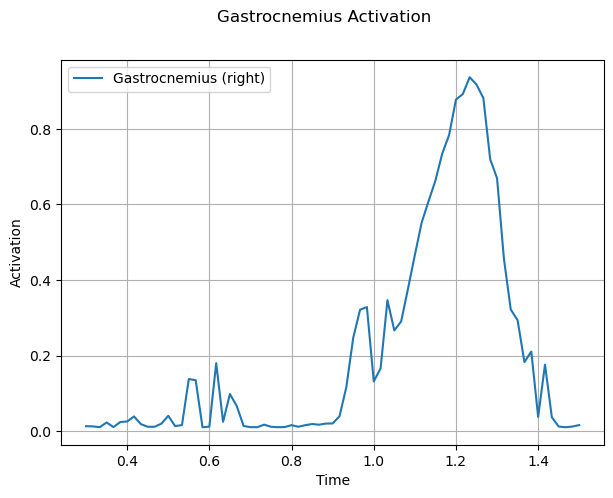

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Gastrocnemius Activation')

# Plot the knee angles on the first subplot.
axs.plot(time_activation, gastrocnemius_muscle_activation.to_numpy(), label='Gastrocnemius (right)')
axs.set_xlabel('Time')
axs.set_ylabel('Activation')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

**Results Explanation**

What exactly is happening? If you check the output of the Static Optimization execution (when you executed run on the AnalyzeTool), there is an error message saying **Optimizer Failed...**. This is informing you that the optimizer could not find an adequate solution at the time indicated. However, it is not crashing since the Tool is trying to find adequate solutions in the following times. Remember that Static Optimization is trying to calculate activations and muscle forces that satisfy the model's coordinate accelerations calculated from the specified kinematics file. If the model's actuators cannot generate sufficient forces to match these accelerations, this "Optimizer Failed..." error will appear. The Static Optimization tool has produced a set of results to help with troubleshooting, but these outputs are not valid.

An under-actuated model is the product of muscles not being strong enough to generate the required forces and/or model coordinates not having any actuation (muscles or other actuators). In this particular model, there are no muscles that control lumbar flexion/extension, so all the other lower limb muscles are trying to control trunk motion, without much success. 

One possible solution is to add extra muscles that cross the lumbar joint. However in this series of studies we are only interested in Gastrocnemius activation during walking. Adding additional muscles will add extra complexity to the model that is likely not required for our analysis. Instead of lumbar muscles, we will add a torque actuator at the lumbar joint.

We will also add reserve and residual actuators to the model. Reserve actuators can add extra actuation during portions of the gait cycle where muscles are not able to generate sufficient accelerations (e.g., during a spike in acceleration). Residual actuators are "hand of God" forces that account for (what should be small) discrepancies between the model, measured motions, and forces; in other words, these actuators ensure that Newton's 2$^{nd}$ law, $F=m*a$, is satisfied throughout the analysis. For more details, see _Section 3.1.3_ of [[1](https://doi.org/10.1115/1.4029304)]. Typically, these residual actuators are added to the model's body that is connected to ground (in this particular case, residual actuators will be added to the pelvis body).

### 6.3.2. Adding Actuators to the Model

You will now add a set of additional residual actuators to fix the errors obtained in the previous section. This includes a lumbar actuator, reserve actuators at the other joints, and residual actuators at the pelvis. Once you have added the actuatiors, you will rerun the analysis to check if the problem is solved.

**Download the files**

First, let's download the actuators file (`gait10dof18musc_Strong_actuators.xml`). The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
# !gdown "1Tvj8lEjKt-cTvJ1oQ-YrpDcC4M8TXDou&confirm=t" # gait10dof18musc_Strong_actuators.xml

**Create Static Optimization Analysis Tool**

Now, let's add actuators to the Analyze Tool. You don't need to add the actuators manually since you have downloaded a file defining them (`gait10dof18musc_Strong_actuators.xml`). 

In order to preserve previous results, we are going to change the name of the analysis tool and the name of the output folder.

In [15]:
# Create analyze tool for static optimization.
so_strong_analyze_tool = osim.AnalyzeTool()
so_strong_analyze_tool.setName("SO_Strong")

# Add actuators file.
forceSet_files = osim.ArrayStr()
forceSet_files.append("gait10dof18musc_Strong_actuators.xml")
so_strong_analyze_tool.setForceSetFiles(forceSet_files)

# Set model file, motion files and external load file names.
so_strong_analyze_tool.setModelFilename("gait10dof18musc_simbody.osim")
so_strong_analyze_tool.setCoordinatesFileName("subject01_walk_IK.mot")
so_strong_analyze_tool.setExternalLoadsFileName("subject01_walk_grf.xml")

# Add analysis.
so_strong_analyze_tool.updAnalysisSet().cloneAndAppend(so)

# Configure analyze tool.
so_strong_analyze_tool.setReplaceForceSet(False)
so_strong_analyze_tool.setStartTime(start_time)
so_strong_analyze_tool.setFinalTime(end_time)

# Directory where results are stored.
so_strong_analyze_tool.setResultsDir("SO_Strong_Results")

# Print configuration of analyze tool to a xml file.
so_strong_analyze_tool.printToXML("SO_Strong_AnalyzeTool_setup.xml")

# Load configuration and run the analyses. 
so_strong_analyze_tool = osim.AnalyzeTool("SO_Strong_AnalyzeTool_setup.xml", True)

AbstractTool SO_Strong loading model gait10dof18musc_simbody.osim

Updating Model file from 30000 to latest format...

Loaded model Scaled_Model from file gait10dof18musc_simbody.osim

Couldn't find file 'sacrum.vtp'.

Couldn't find file 'pelvis.vtp'.

Couldn't find file 'l_pelvis.vtp'.

Couldn't find file 'femur_r.vtp'.

Couldn't find file 'tibia_r.vtp'.

Couldn't find file 'fibula.vtp'.

Couldn't find file 'talus.vtp'.

Couldn't find file 'foot.vtp'.

Couldn't find file 'bofoot.vtp'.

Couldn't find file 'femur_l.vtp'.

Couldn't find file 'tibia_l.vtp'.

Couldn't find file 'l_fibula.vtp'.

Couldn't find file 'l_talus.vtp'.

Couldn't find file 'l_foot.vtp'.

Couldn't find file 'l_bofoot.vtp'.

Couldn't find file 'hat_spine.vtp'.

Couldn't find file 'hat_jaw.vtp'.

Couldn't find file 'hat_skull.vtp'.

Couldn't find file 'hat_ribs.vtp'.

ControllerSet 'Controllers' was renamed and is being reset to 'controllerset'.

ComponentSet 'MiscComponents' was renamed and is being reset to 'compone

**Perform Static Optimization**

Finally, we can perform Static Optimization on the model with the actuators. Notice how this time the calculations are faster, solutions are found at each time point, and there are no errors during the execution.

In [16]:
# Run static optimization.
so_strong_analyze_tool.run()

ExternalLoads 'WalkingGRF' was renamed and is being reset to 'externalloads'.

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Loading coordinates from file 'subject01_walk_IK.mot'.

Storage: read data file = subject01_walk_IK.mot (nr=151 nc=11)

Found 151 state vectors with time stamps ranging from 0.0 to 2.5.

Executing the analyses from 0.3 to 1.5...

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

time = 0.3 Performance = 2.82042 Constraint violation = 1.82574e-12

B

True

**Plot Results**

First, plot the lumbar actuator reserves from the output file `Static_Optimization_Strong_StaticOptimization_force.sto`.

In [17]:
# Get results from file.
table_forces = osim.TimeSeriesTable(
    "SO_Strong_Results/SO_Strong_StaticOptimization_force.sto")

# Get values.
time_force = table_forces.getIndependentColumn()
lumbar_extension_reserve = table_forces.getDependentColumn("lumbar_extension_reserve")

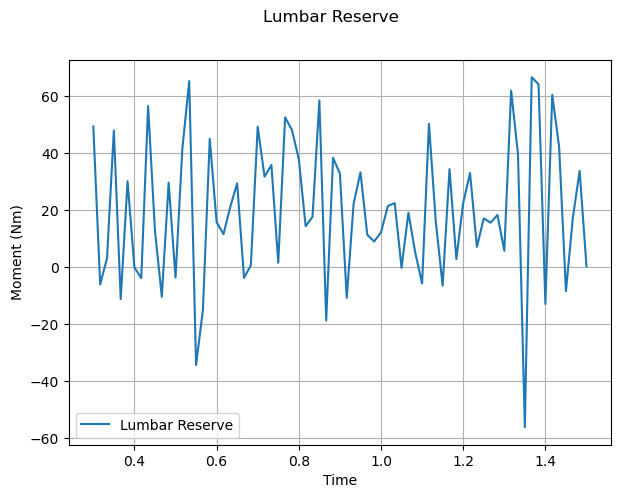

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Lumbar Reserve')

# Plot the knee angles on the first subplot.
axs.plot(time_force, lumbar_extension_reserve.to_numpy(), label='Lumbar Reserve')
axs.set_xlabel('Time')
axs.set_ylabel('Moment (Nm)')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Now, let's compare the gastrocnemius muscle activation curves from the two analyses (with and without additional actuators).

In [19]:
# Get results from file.
table_activation = osim.TimeSeriesTable(
    "SO_Strong_Results/SO_Strong_StaticOptimization_activation.sto")

# Get values.
time_activation = table_activation.getIndependentColumn()
gastrocnemius_muscle_activation_actuation = table_activation.getDependentColumn("gastroc_r")

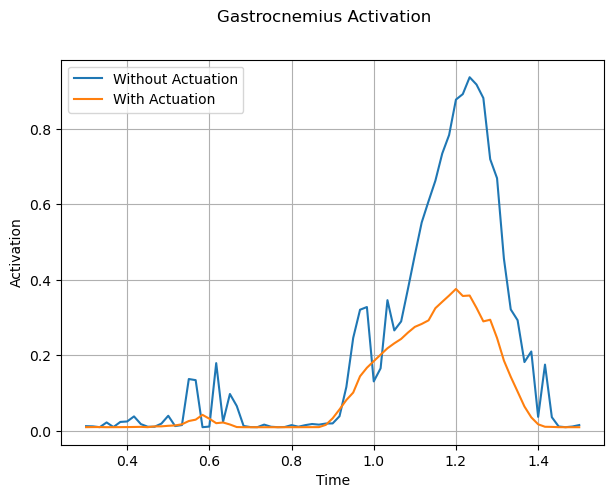

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Gastrocnemius Activation')

# Plot the knee angles on the first subplot.
axs.plot(time_activation, gastrocnemius_muscle_activation.to_numpy(), label='Without Actuation')
axs.plot(time_activation, gastrocnemius_muscle_activation_actuation.to_numpy(), label='With Actuation')
axs.set_xlabel('Time')
axs.set_ylabel('Activation')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

The previous figure shows that the gastrocnemius activation was significantly reduced. The reduction is due to the additional torques generated by the actuators added to the model.

Plot the moments produced by the right ankle reserve actuator from the output file `Static_Optimization_Strong_StaticOptimization_force.sto`.

In [21]:
# Get results from file.
table_force = osim.TimeSeriesTable(
    "SO_Strong_Results/SO_Strong_StaticOptimization_force.sto")

# Get values.
time_force = table_force.getIndependentColumn()
ankle_angle_r_reserve_force = table_force.getDependentColumn("ankle_angle_r_reserve")

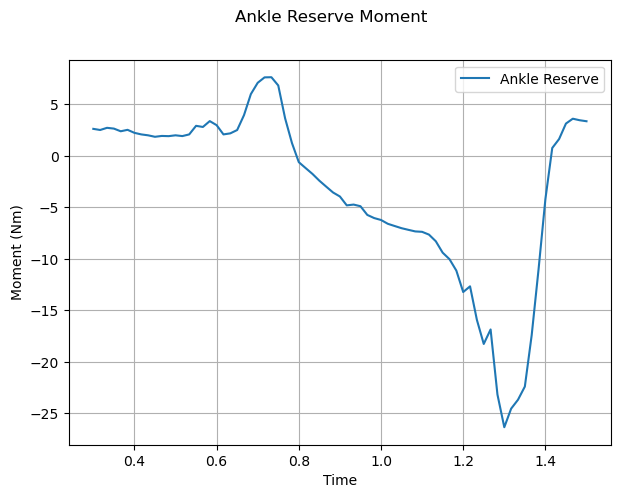

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Ankle Reserve Moment')

# Plot the knee angles on the first subplot.
axs.plot(time_activation, ankle_angle_r_reserve_force.to_numpy(), label='Ankle Reserve')
axs.set_xlabel('Time')
axs.set_ylabel('Moment (Nm)')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Finally, plot the forces `Fx`, `Fy`, and moment `Mz` residual actuator forces.

In [23]:
# Get results from file.
table_force = osim.TimeSeriesTable(
    "SO_Strong_Results/SO_Strong_StaticOptimization_force.sto")

# Get values.
time_force = table_force.getIndependentColumn()
fx = table_force.getDependentColumn("FX")
fy = table_force.getDependentColumn("FY")
mz = table_force.getDependentColumn("MZ")

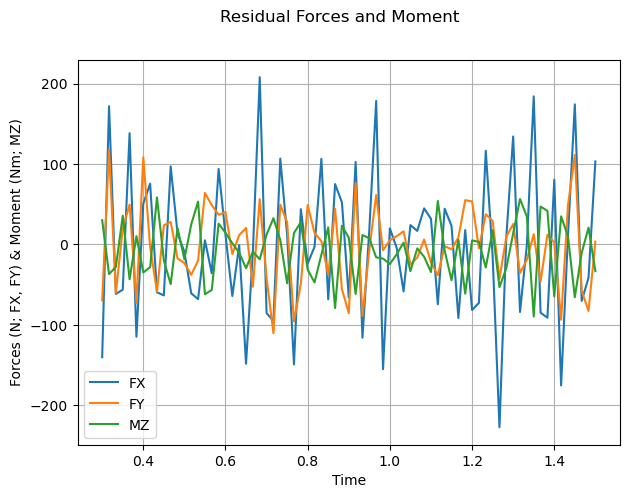

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Residual Forces and Moment')

# Plot the knee angles on the first subplot.
axs.plot(time_force, fx.to_numpy(), label='FX')
axs.plot(time_force, fy.to_numpy(), label='FY')
axs.plot(time_force, mz.to_numpy(), label='MZ')
axs.set_xlabel('Time')
axs.set_ylabel('Forces (N; FX, FY) & Moment (Nm; MZ)')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

**Results Explanation:**

We now have a working Static Optimization analysis. A functioning analysis does not mean that the results are valid; rather, we have a place to start iterating from to improve the output. In the following studies, we will gradually improve the quality of the inputs to get a better result. Review the questions below to better understand the problems with the current set of results.

**Questions:**

*   The activation and force results are very noisy; why do you think  this is? We will learn how to fix this in Study 2.

*   The Mz contribution is between ±50 Nm. What is the contribution of the residual actuator force for Fx, and Fy? How large are these residual actuator forces in comparison to the peak ground reaction forces measured doing the motion? What improvements could you make to any of the inputs (model, kinematics, external forces) to reduce the size of the residual forces? Study 2 will address these residual results. 

*   The peak ankle extension moment from Inverse Dynamics was 120 Nm. How does this peak ankle moment compare to the peak moment generated by the ankle reserve actuator. (e.g., as a percentage)? Do you think the reserve actuator peak should be this large? How might we address this issue? We will learn how to fix this in Study 3.

## 6.4. Study 2: Improving the input kinematics

The aim of Study 2 is to assess how improving the input kinematics affects muscle activations and forces calculated by Static Optimization. Static Optimization is trying to compute muscle forces that generate the accelerations seen in the input kinematics. If these accelerations are noisy, there will be noise in the muscle activations and forces. In Study 1, we saw noisy activations and forces that are most likely the result of noisy motion data. We will investigate two methods for improving the motion data:
*  Filtering the input kinematics.
*  Using the Residual Reduction Algorithm (RRA) to generate a dynamically consistent motion with consistent accelerations

Filtering the kinematics will spline-fit the motion data and filter the coordinate positions, reducing noise in the accelerations. If you use IK results as inputs to Static Optimization, you should always filter them, either externally (e.g., with Matlab or Python) or by using the OpenSim filters.

Since RRA uses a forward dynamics simulation (i.e., the model's equations of motion are integrated forward in time), the output kinematics will be consistent accelerations that are great to use in Static Optimization. If you are using RRA results, you don't need to do any additional filtering. Using RRA also has the added benefit of generating a more "dynamically consistent" model and set of kinematics and forces. We are not going to go in depth into RRA in this particular tutorial so if you are unfamiliar with RRA please refer to the [User's Guide](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Residual+Reduction+Algorithm).

### 6.4.1. Filter the motion using a low pass filter

**Create Static Optimization Analysis Tool**

Let's create a Static Optimization Tool, but this time we have to append the reserve and residal actuators from the beginning, filter the motion using 6Hz cut-off, and change the output directory name, so results are not overwritten.

In [25]:
# Create analyze tool for static optimization.
so_strong_filter_analyze_tool = osim.AnalyzeTool()
so_strong_filter_analyze_tool.setName("SO_Strong_Filter")

# Add actuators file.
forceSet_files = osim.ArrayStr()
forceSet_files.append("gait10dof18musc_Strong_actuators.xml")
so_strong_filter_analyze_tool.setForceSetFiles(forceSet_files)

# Set model file, motion files and external load file names.
so_strong_filter_analyze_tool.setModelFilename("gait10dof18musc_simbody.osim")
so_strong_filter_analyze_tool.setCoordinatesFileName("subject01_walk_IK.mot")
so_strong_filter_analyze_tool.setExternalLoadsFileName("subject01_walk_grf.xml")

# Change low pass frequency to filter the model.
so_strong_filter_analyze_tool.setLowpassCutoffFrequency(6)

# Add analysis.
so_strong_filter_analyze_tool.updAnalysisSet().cloneAndAppend(so)

# Configure analyze tool.
so_strong_filter_analyze_tool.setReplaceForceSet(False)
so_strong_filter_analyze_tool.setStartTime(start_time)
so_strong_filter_analyze_tool.setFinalTime(end_time)

# Directory where results are stored.
so_strong_filter_analyze_tool.setResultsDir("SO_Strong_Filter_Results")

# Print configuration of analyze tool to a xml file.
so_strong_filter_analyze_tool.printToXML("SO_Strong_Filter_AnalyzeTool_setup.xml")

# Load configuration and run the analyses. 
so_strong_filter_analyze_tool = osim.AnalyzeTool("SO_Strong_Filter_AnalyzeTool_setup.xml", True)

AbstractTool SO_Strong_Filter loading model gait10dof18musc_simbody.osim

Updating Model file from 30000 to latest format...

Loaded model Scaled_Model from file gait10dof18musc_simbody.osim

Couldn't find file 'sacrum.vtp'.

Couldn't find file 'pelvis.vtp'.

Couldn't find file 'l_pelvis.vtp'.

Couldn't find file 'femur_r.vtp'.

Couldn't find file 'tibia_r.vtp'.

Couldn't find file 'fibula.vtp'.

Couldn't find file 'talus.vtp'.

Couldn't find file 'foot.vtp'.

Couldn't find file 'bofoot.vtp'.

Couldn't find file 'femur_l.vtp'.

Couldn't find file 'tibia_l.vtp'.

Couldn't find file 'l_fibula.vtp'.

Couldn't find file 'l_talus.vtp'.

Couldn't find file 'l_foot.vtp'.

Couldn't find file 'l_bofoot.vtp'.

Couldn't find file 'hat_spine.vtp'.

Couldn't find file 'hat_jaw.vtp'.

Couldn't find file 'hat_skull.vtp'.

Couldn't find file 'hat_ribs.vtp'.

ControllerSet 'Controllers' was renamed and is being reset to 'controllerset'.

ComponentSet 'MiscComponents' was renamed and is being reset to '

**Perform Static Optimization**

We can perform Static Optimization on the model with the filtered motion.

In [26]:
# Run static optimization.
so_strong_filter_analyze_tool.run()

ExternalLoads 'WalkingGRF' was renamed and is being reset to 'externalloads'.

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Loading coordinates from file 'subject01_walk_IK.mot'.

Storage: read data file = subject01_walk_IK.mot (nr=151 nc=11)

Low-pass filtering coordinates data with a cutoff frequency of 6.0...

Found 301 state vectors with time stamps ranging from -1.25 to 3.75.

Executing the analyses from 0.299999 to 1.5...

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_

True

### 6.4.2. Smoothening the motion using RRA

**Download the files**

First, let's download the RRA motion file (`subject_adjusted_Kinematics_q.sto`). The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
# !gdown "1d8JyqSsLcXWuboUGkRvFLmsTfprNIklN&confirm=t" # subject_adjusted_Kinematics_q.sto

**Create Static Optimization Analysis Tool**

Let's create a Static Optimization Tool, but this time we have to use the motion file kinematics generated by RRA (`subject_adjusted_Kinematics_q.sto`). Remember we are use RRA results so the kinematics are smoother. This time do not apply a low pass filter, and change the step interval to 10. Again, change the output folder for the file so we don't overwrite previous results.

In [27]:
# Define a StaticOptimization object.
so_rra = osim.StaticOptimization()

# Set start and end times for the analysis.
start_time = 0.3
end_time = 1.5
so_rra.setStartTime(start_time)
so_rra.setEndTime(end_time)

# Step interval.
so_rra.setStepInterval(10)

In [28]:
# Create analyze tool for static optimization.
so_strong_RRA_analyze_tool = osim.AnalyzeTool()
so_strong_RRA_analyze_tool.setName("SO_Strong_RRA")

# Add actuators file.
forceSet_files = osim.ArrayStr()
forceSet_files.append("gait10dof18musc_Strong_actuators.xml")
so_strong_RRA_analyze_tool.setForceSetFiles(forceSet_files)

# Set model file, motion files and external load file names.
so_strong_RRA_analyze_tool.setModelFilename("gait10dof18musc_simbody.osim")
so_strong_RRA_analyze_tool.setCoordinatesFileName("subject_adjusted_Kinematics_q.sto")
so_strong_RRA_analyze_tool.setExternalLoadsFileName("subject01_walk_grf.xml")

# Add analysis.
so_strong_RRA_analyze_tool.updAnalysisSet().cloneAndAppend(so_rra)

# Configure analyze tool.
so_strong_RRA_analyze_tool.setReplaceForceSet(False)
so_strong_RRA_analyze_tool.setStartTime(start_time)
so_strong_RRA_analyze_tool.setFinalTime(end_time)

# Directory where results are stored.
so_strong_RRA_analyze_tool.setResultsDir("SO_Strong_RRA_Results")

# Print configuration of analyze tool to a xml file.
so_strong_RRA_analyze_tool.printToXML("SO_Strong_RRA_AnalyzeTool_setup.xml")

# Load configuration and run the analyses. 
so_strong_RRA_analyze_tool = osim.AnalyzeTool("SO_Strong_RRA_AnalyzeTool_setup.xml", True)

AbstractTool SO_Strong_RRA loading model gait10dof18musc_simbody.osim

Updating Model file from 30000 to latest format...

Loaded model Scaled_Model from file gait10dof18musc_simbody.osim

Couldn't find file 'sacrum.vtp'.

Couldn't find file 'pelvis.vtp'.

Couldn't find file 'l_pelvis.vtp'.

Couldn't find file 'femur_r.vtp'.

Couldn't find file 'tibia_r.vtp'.

Couldn't find file 'fibula.vtp'.

Couldn't find file 'talus.vtp'.

Couldn't find file 'foot.vtp'.

Couldn't find file 'bofoot.vtp'.

Couldn't find file 'femur_l.vtp'.

Couldn't find file 'tibia_l.vtp'.

Couldn't find file 'l_fibula.vtp'.

Couldn't find file 'l_talus.vtp'.

Couldn't find file 'l_foot.vtp'.

Couldn't find file 'l_bofoot.vtp'.

Couldn't find file 'hat_spine.vtp'.

Couldn't find file 'hat_jaw.vtp'.

Couldn't find file 'hat_skull.vtp'.

Couldn't find file 'hat_ribs.vtp'.

ControllerSet 'Controllers' was renamed and is being reset to 'controllerset'.

ComponentSet 'MiscComponents' was renamed and is being reset to 'com

**Perform Static Optimization**

We can now perform Static Optimization on the model with the smoothened motion.

In [29]:
# Run static optimization.
so_strong_RRA_analyze_tool.run()

ExternalLoads 'WalkingGRF' was renamed and is being reset to 'externalloads'.

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Loading coordinates from file 'subject_adjusted_Kinematics_q.sto'.

Storage: read data file = subject_adjusted_Kinematics_q.sto (nr=2537 nc=11)

Found 2536 state vectors with time stamps ranging from 0.0 to 2.499.

Executing the analyses from 0.3 to 1.5...

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

time = 0.3 Performance = 0.0802230 Constra

True

### 6.4.3. Comparing results

You should now have four analysis results in separate folders

*  **1. SO_Results**: Static Optimization, no extra actuation (residuals and reserves), unfiltered IK motion.
*  **2. SO_Strong_Results**: Static Optimization, with extra actuation, unfiltered IK motion.
*  **3. SO_Strong_Filter_Results**: Static Optimization, with extra actuation, filtered IK motion.
*  **4. SO_Strong_RRA_Results**: Static Optimization, with extra actuation, RRA motion.

**Plot Results**

Generate figures that compare the gastrocnemius activations for the three different kinematics inputs (**2. unfiltered**, **3. filtered**, and **4. RRA**) where reserve and residual actuators were included (i.e., skip case 1).

In [30]:
# Get results from file.
table_activation_SO_Strong = osim.TimeSeriesTable(
    "SO_Strong_Results/SO_Strong_StaticOptimization_activation.sto")

# Get values.
time_SO_Strong = table_activation_SO_Strong.getIndependentColumn()
gastrocnemius_muscle_activation_strong = table_activation_SO_Strong.getDependentColumn("gastroc_r")

# Get results from file.
table_activation_SO_Strong_Filter = osim.TimeSeriesTable(
    "SO_Strong_Filter_Results/SO_Strong_Filter_StaticOptimization_activation.sto")

# Get values.
time_SO_Strong_Filter = table_activation_SO_Strong_Filter.getIndependentColumn()
gastrocnemius_muscle_activation_strong_filtered = table_activation_SO_Strong_Filter.getDependentColumn("gastroc_r")

# Get results from file.
table_activation_SO_Strong_RRA = osim.TimeSeriesTable(
    "SO_Strong_RRA_Results/SO_Strong_RRA_StaticOptimization_activation.sto")

# Get values.
time_SO_Strong_RRA = table_activation_SO_Strong_RRA.getIndependentColumn()
gastrocnemius_muscle_activation_strong_rra = table_activation_SO_Strong_RRA.getDependentColumn("gastroc_r")

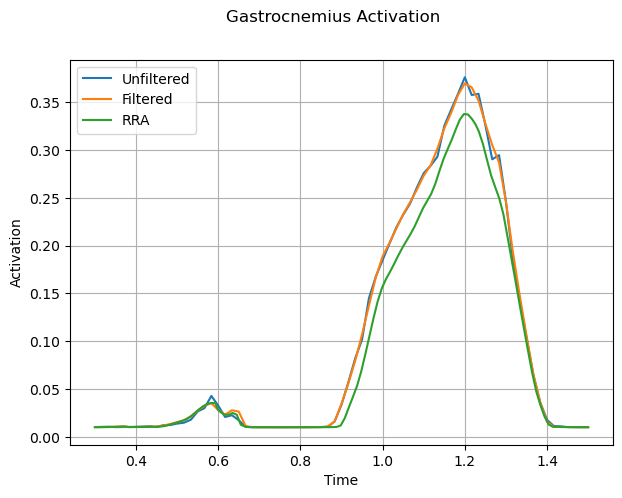

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Gastrocnemius Activation')

# Plot the knee angles on the first subplot.
axs.plot(time_SO_Strong, gastrocnemius_muscle_activation_strong.to_numpy(), label='Unfiltered')
axs.plot(time_SO_Strong_Filter, gastrocnemius_muscle_activation_strong_filtered.to_numpy(), label='Filtered')
axs.plot(time_SO_Strong_RRA, gastrocnemius_muscle_activation_strong_rra.to_numpy(), label='RRA')
axs.set_xlabel('Time')
axs.set_ylabel('Activation')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Plot the `Fx` residual for the three kinematics inputs (**2. unfiltered**, **3. filtered**, and **4. RRA**).

In [32]:
# Get results from file.
table_forces_SO_Strong = osim.TimeSeriesTable(
    "SO_Strong_Results/SO_Strong_StaticOptimization_force.sto")

# Get values.
time_SO_Strong = table_forces_SO_Strong.getIndependentColumn()
fx_strong = table_forces_SO_Strong.getDependentColumn("FX")

# Get results from file.
table_forces_SO_Strong_Filter = osim.TimeSeriesTable(
    "SO_Strong_Filter_Results/SO_Strong_Filter_StaticOptimization_force.sto")

# Get values.
time_SO_Strong_Filter = table_forces_SO_Strong_Filter.getIndependentColumn()
fx_strong_filtered = table_forces_SO_Strong_Filter.getDependentColumn("FX")

# Get results from file.
table_forces_SO_Strong_RRA = osim.TimeSeriesTable(
    "SO_Strong_RRA_Results/SO_Strong_RRA_StaticOptimization_force.sto")

# Get values.
time_SO_Strong_RRA = table_forces_SO_Strong_RRA.getIndependentColumn()
fx_strong_rra = table_forces_SO_Strong_RRA.getDependentColumn("FX")

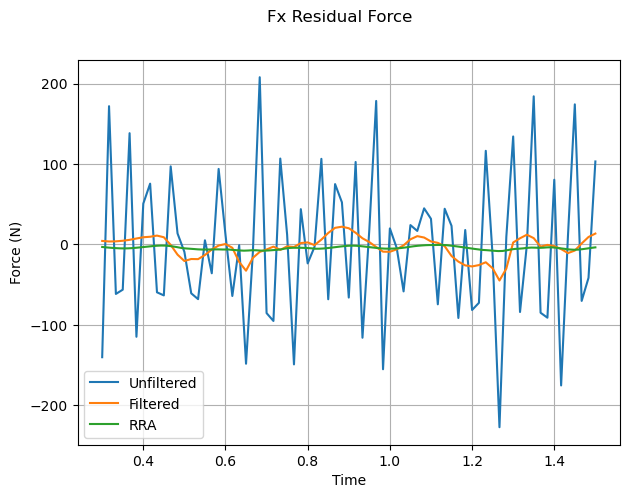

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Fx Residual Force')

# Plot the knee angles on the first subplot.
axs.plot(time_SO_Strong, fx_strong.to_numpy(), label='Unfiltered')
axs.plot(time_SO_Strong_Filter, fx_strong_filtered.to_numpy(), label='Filtered')
axs.plot(time_SO_Strong_RRA, fx_strong_rra.to_numpy(), label='RRA')
axs.set_xlabel('Time')
axs.set_ylabel('Force (N)')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

**Questions**:

*  Describe the changes in muscle activation for the three different motion inputs. 

*  Why did the residual force reduce from the Unfiltered to Filtered condition? Why did the residual force reduce further when using the model and motion from RRA?

*  Which kinematic input should be used for the Static Optimization analysis? Explain your reason(s).

*  Optional: Explore some of the other forces and activation results from the analysis.

## 6.5. Study 3: Tuning the reserve and residual actuators

In Study 2, we added actuators to assist each coordinate of the model. However, we saw that these reserve actuators contributed a significant amount of the total joint torque that we would prefer the muscles to provide. In this Study, you will reduce the strength of the reserve actuators and observe the resulting changes in reserve actuator torques and gastrocnemius muscle activation and forces. 

The current actuators file has optimal forces of $100 N$ for each force actuator (i.e., residuals $FX$ and $FY$) and optimal forces of $100 Nm$ for each torque actuator (i.e., residual $MZ$, and reserve coordinate actuators). When trying to minimize the sum of activations squared, the optimizer can use small activation values to these force and torque actuators to generate large forces or torques. For example, with an optimal torque of $100 Nm$, an activation of $0.5$ will generate a torque of $50 Nm$. If, instead, the optimal force were $1 Nm$, the optimizer must now use very high activations to produce any meaningful torques. In this latter case (optimal torque = 1), an activation of $0.5$ would only generate $0.5 Nm$, and an activation of $50$ is necessary to generate $50 Nm$ of torque. Thus, when the optimal force is very low ($~1 N$ or $1 Nm$) the optimizer can still choose to use the reserve actuators when needed, but the cost is so high relative to the muscles that the optimizer will preferentially use muscles to generate joint torques over the reserve actuators.

**Edit Actuators File**

Edit the actuators file and change each actuator's optimal force from 100 to 1. You can do this programatically by loading the XML file and modifying the values of every element with tag `optimal_force`. The following function does this for you and saves the modified file as `gait10dof18musc_Actuators_Normal.xml`.

In [34]:
from xml.dom import minidom

# Parse the xml file.
file = minidom.parse('gait10dof18musc_Strong_actuators.xml')

# Get all elements with tag name 'optimal_force'.
optimal_forces = file.getElementsByTagName("optimal_force")

# Set all optimal forces to 1.
for optimal_force in optimal_forces:
  optimal_force.firstChild.nodeValue = 1

xml_str = file.toprettyxml(indent ="\t", newl='\r') 

with open("gait10dof18musc_Actuators_Normal.xml", "w") as f:
    f.write(xml_str) 

**Create Static Optimization Analysis Tool**

Perform a new Static Optimization Analysis, but this time use the new Additional Forces Set file (`gait10dof18musc_Actuators_Normal.xml`). Save the results in a different folder so previous results are not overwritten.

In [35]:
# Create analyze tool for static optimization.
so_normal_RRA_analyze_tool = osim.AnalyzeTool()
so_normal_RRA_analyze_tool.setName("SO_Normal_RRA")

# Add actuators file.
forceSet_files = osim.ArrayStr()
forceSet_files.append("gait10dof18musc_Actuators_Normal.xml")
so_normal_RRA_analyze_tool.setForceSetFiles(forceSet_files)

# Set model file, motion files and external load file names.
so_normal_RRA_analyze_tool.setModelFilename("gait10dof18musc_simbody.osim")
so_normal_RRA_analyze_tool.setCoordinatesFileName("subject_adjusted_Kinematics_q.sto")
so_normal_RRA_analyze_tool.setExternalLoadsFileName("subject01_walk_grf.xml")

# Add analysis.
so_normal_RRA_analyze_tool.updAnalysisSet().cloneAndAppend(so_rra)

# Configure analyze tool.
so_normal_RRA_analyze_tool.setReplaceForceSet(False)
so_normal_RRA_analyze_tool.setStartTime(start_time)
so_normal_RRA_analyze_tool.setFinalTime(end_time)

# Directory where results are stored.
so_normal_RRA_analyze_tool.setResultsDir("SO_Normal_RRA_Results")

# Print configuration of analyze tool to a xml file.
so_normal_RRA_analyze_tool.printToXML("SO_Normal_RRA_AnalyzeTool_setup.xml")

# Load configuration and run the analyses. 
so_normal_RRA_analyze_tool = osim.AnalyzeTool("SO_Normal_RRA_AnalyzeTool_setup.xml", True)

AbstractTool SO_Normal_RRA loading model gait10dof18musc_simbody.osim

Updating Model file from 30000 to latest format...

Loaded model Scaled_Model from file gait10dof18musc_simbody.osim

Couldn't find file 'sacrum.vtp'.

Couldn't find file 'pelvis.vtp'.

Couldn't find file 'l_pelvis.vtp'.

Couldn't find file 'femur_r.vtp'.

Couldn't find file 'tibia_r.vtp'.

Couldn't find file 'fibula.vtp'.

Couldn't find file 'talus.vtp'.

Couldn't find file 'foot.vtp'.

Couldn't find file 'bofoot.vtp'.

Couldn't find file 'femur_l.vtp'.

Couldn't find file 'tibia_l.vtp'.

Couldn't find file 'l_fibula.vtp'.

Couldn't find file 'l_talus.vtp'.

Couldn't find file 'l_foot.vtp'.

Couldn't find file 'l_bofoot.vtp'.

Couldn't find file 'hat_spine.vtp'.

Couldn't find file 'hat_jaw.vtp'.

Couldn't find file 'hat_skull.vtp'.

Couldn't find file 'hat_ribs.vtp'.

ControllerSet 'Controllers' was renamed and is being reset to 'controllerset'.

ComponentSet 'MiscComponents' was renamed and is being reset to 'com

**Perform Static Optimization**

We can now perform Static Optimization with the residual and reserve actuators each with an optimal force of 1.

In [36]:
# Run static optimization.
so_normal_RRA_analyze_tool.run()

ExternalLoads 'WalkingGRF' was renamed and is being reset to 'externalloads'.

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Loading coordinates from file 'subject_adjusted_Kinematics_q.sto'.

Storage: read data file = subject_adjusted_Kinematics_q.sto (nr=2537 nc=11)

Found 2536 state vectors with time stamps ranging from 0.0 to 2.499.

Executing the analyses from 0.3 to 1.5...

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

time = 0.3 Performance = 529.681 Constrain

True

**Plot Results**

Once the analysis has finished, plot the gastrocnemius activation when using the strong actuators (optimal force of 100) vs the normal actuators (optimal force of 1).

In [37]:
# Get results from file.
table_activation_SO_Strong_RRA = osim.TimeSeriesTable(
    "SO_Strong_RRA_Results/SO_Strong_RRA_StaticOptimization_activation.sto")

# Get values.
time_SO_Strong_RRA = table_activation_SO_Strong_RRA.getIndependentColumn()
gastrocnemius_muscle_activation_strong_rra = table_activation_SO_Strong_RRA.getDependentColumn("gastroc_r")

# Get results from file.
table_activation_SO_Normal_RRA = osim.TimeSeriesTable(
    "SO_Normal_RRA_Results/SO_Normal_RRA_StaticOptimization_activation.sto")

# Get values.
time_SO_Normal_RRA = table_activation_SO_Normal_RRA.getIndependentColumn()
gastrocnemius_muscle_activation_normal_rra = table_activation_SO_Normal_RRA.getDependentColumn("gastroc_r")

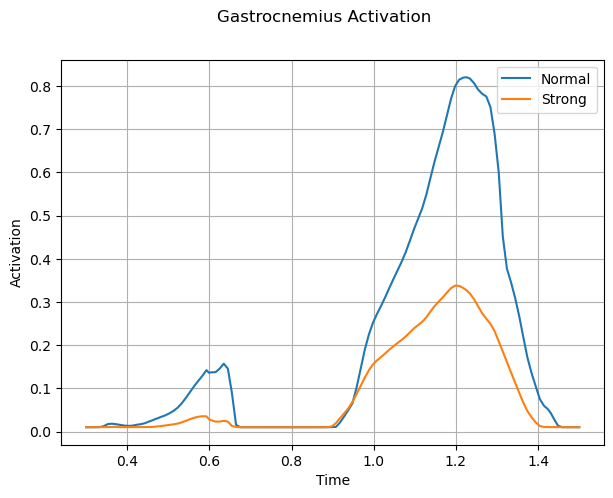

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Gastrocnemius Activation')

# Plot the knee angles on the first subplot.
axs.plot(time_SO_Normal_RRA, gastrocnemius_muscle_activation_normal_rra.to_numpy(), label='Normal')
axs.plot(time_SO_Strong_RRA, gastrocnemius_muscle_activation_strong_rra.to_numpy(), label='Strong')
axs.set_xlabel('Time')
axs.set_ylabel('Activation')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Plot and compare the lumbar actuator moment.

In [39]:
# Get results from file.
table_forces_SO_Strong_RRA = osim.TimeSeriesTable(
    "SO_Strong_RRA_Results/SO_Strong_RRA_StaticOptimization_force.sto")

# Get values.
time_SO_Strong_RRA = table_forces_SO_Strong_RRA.getIndependentColumn()
lumbar_actuator_moment_strong_rra = table_forces_SO_Strong_RRA.getDependentColumn("lumbar_extension_reserve")

# Get results from file.
table_forces_SO_Normal_RRA = osim.TimeSeriesTable(
    "SO_Normal_RRA_Results/SO_Normal_RRA_StaticOptimization_force.sto")

# Get values.
time_SO_Normal_RRA = table_forces_SO_Normal_RRA.getIndependentColumn()
lumbar_actuator_moment_normal_rra = table_forces_SO_Normal_RRA.getDependentColumn("lumbar_extension_reserve")

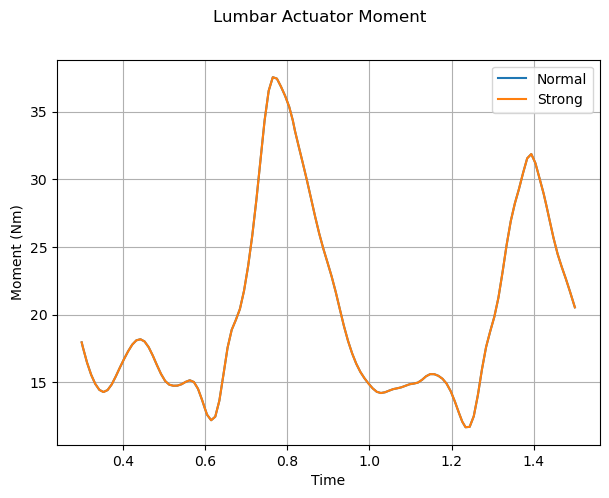

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Lumbar Actuator Moment')

# Plot the knee angles on the first subplot.
axs.plot(time_SO_Normal_RRA, lumbar_actuator_moment_normal_rra.to_numpy(), label='Normal')
axs.plot(time_SO_Strong_RRA, lumbar_actuator_moment_strong_rra.to_numpy(), label='Strong')
axs.set_xlabel('Time')
axs.set_ylabel('Moment (Nm)')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Plot and compare the ankle reserve actuator moment.

In [41]:
# Get results from file.
table_forces_SO_Strong_RRA = osim.TimeSeriesTable(
    "SO_Strong_RRA_Results/SO_Strong_RRA_StaticOptimization_force.sto")

# Get values.
time_SO_Strong_RRA = table_forces_SO_Strong_RRA.getIndependentColumn()
ankle_r_actuator_moment_strong_rra = table_forces_SO_Strong_RRA.getDependentColumn("ankle_angle_r_reserve")

# Get results from file.
table_forces_SO_Normal_RRA = osim.TimeSeriesTable(
    "SO_Normal_RRA_Results/SO_Normal_RRA_StaticOptimization_force.sto")

# Get values.
time_SO_Normal_RRA = table_forces_SO_Normal_RRA.getIndependentColumn()
ankle_r_actuator_moment_normal_rra = table_forces_SO_Normal_RRA.getDependentColumn("ankle_angle_r_reserve")

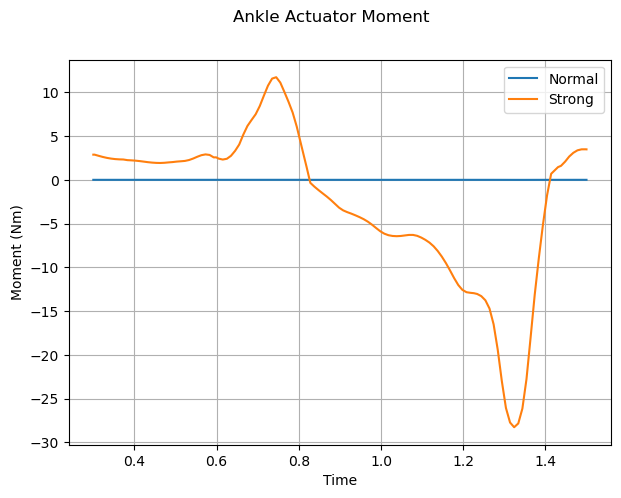

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Ankle Actuator Moment')

# Plot the knee angles on the first subplot.
axs.plot(time_SO_Normal_RRA, ankle_r_actuator_moment_normal_rra.to_numpy(), label='Normal')
axs.plot(time_SO_Strong_RRA, ankle_r_actuator_moment_strong_rra.to_numpy(), label='Strong')
axs.set_xlabel('Time')
axs.set_ylabel('Moment (Nm)')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Finally, plot and compare the `Fx` residual force when using the strong actuators (optimal force at 100) and normal actuators (optimal force at 1)

In [43]:
# Get results from file.
table_forces_SO_Strong_RRA = osim.TimeSeriesTable(
    "SO_Strong_RRA_Results/SO_Strong_RRA_StaticOptimization_force.sto")

# Get values.
time_SO_Strong_RRA = table_forces_SO_Strong_RRA.getIndependentColumn()
fx_strong_rra = table_forces_SO_Strong_RRA.getDependentColumn("FX")

# Get results from file.
table_forces_SO_Normal_RRA = osim.TimeSeriesTable(
    "SO_Normal_RRA_Results/SO_Normal_RRA_StaticOptimization_force.sto")

# Get values.
time_SO_Normal_RRA = table_forces_SO_Normal_RRA.getIndependentColumn()
fx_normal_rra = table_forces_SO_Normal_RRA.getDependentColumn("FX")

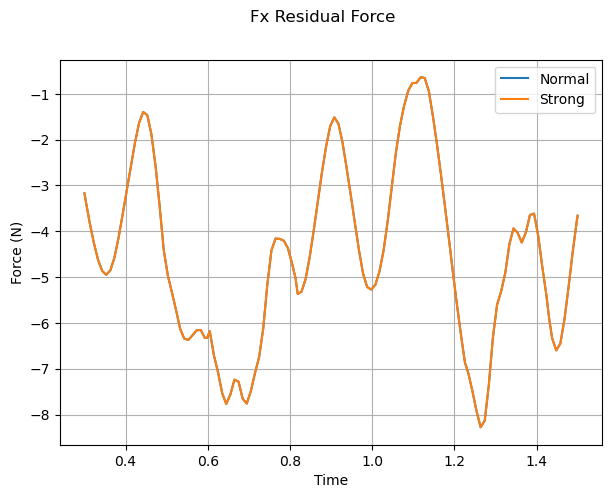

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Fx Residual Force')

# Plot the knee angles on the first subplot.
axs.plot(time_SO_Normal_RRA, fx_normal_rra.to_numpy(), label='Normal')
axs.plot(time_SO_Strong_RRA, fx_strong_rra.to_numpy(), label='Strong')
axs.set_xlabel('Time')
axs.set_ylabel('Force (N)')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

**Questions**

*  How does the gastrocnemius muscle force change between the analysis using strong actuators (optimal force at 100) and the normal (optimal force at 1) actuators? What about the moment generated by the ankle reserve actuators? If there are differences, explain why.

*  How does the lumbar actuator reserve moment change between using the strong vs. normal optimal force? Why might this be the case? (Hint: observe whether or not there are muscles that control the lumbar extension degree of freedom.)

*  What is the peak `Fx` residual force? Why does the value stay the same between the strong and normal actuator case? (Hint: refer to the section earlier in the tutorial where we discuss why we need residual forces and moments. Are there other actuators in the model that could generate these forces?)

## 6.6. Study 4: Static Optimization with a passive element 


In this Study, you will add an ankle spring to the model and observe the effect on gastrocnemius activation.

**Add a Spring to the Model**

The first step is to add a coordinate spring to the model. The following cell adds the spring for you. A new model named `gait10dof18musc_spring.osim` will be generated. Explore the different properties of the spring (e.g., Stiffness, Limit, Damping...).

In [45]:
# Get a handle to the current model and create a new copy 
ankleSpringModel = osim.Model('gait10dof18musc_simbody.osim')
ankleSpringModel.setName(ankleSpringModel.getName()+'_ankle_spring')

# Create the spring we'll add to the model (a CoordinateLimitForce in OpenSim)
ankleSpring = osim.CoordinateLimitForce()

# Set the coordinate for the spring
ankleSpring.set_coordinate('ankle_angle_r')
ankleSpring.setName('AnkleLimitSpringDamper')

# Add the spring to the model
ankleSpringModel.addForce(ankleSpring)

# Set the spring's properties
ankleSpring.setUpperStiffness(30.0)
ankleSpring.setUpperLimit(5.0)
ankleSpring.setLowerStiffness(1.0)
ankleSpring.setLowerLimit(-90.0)
ankleSpring.setDamping(0.01)
ankleSpring.setTransition(2.0)

# Save the model to file
fullPathName = ankleSpringModel.getInputFileName()
newName = fullPathName.replace('.osim', '_spring.osim')
ankleSpringModel.printToXML(newName)

Updating Model file from 30000 to latest format...

Loaded model Scaled_Model from file gait10dof18musc_simbody.osim

Couldn't find file 'sacrum.vtp'.

Couldn't find file 'pelvis.vtp'.

Couldn't find file 'l_pelvis.vtp'.

Couldn't find file 'femur_r.vtp'.

Couldn't find file 'tibia_r.vtp'.

Couldn't find file 'fibula.vtp'.

Couldn't find file 'talus.vtp'.

Couldn't find file 'foot.vtp'.

Couldn't find file 'bofoot.vtp'.

Couldn't find file 'femur_l.vtp'.

Couldn't find file 'tibia_l.vtp'.

Couldn't find file 'l_fibula.vtp'.

Couldn't find file 'l_talus.vtp'.

Couldn't find file 'l_foot.vtp'.

Couldn't find file 'l_bofoot.vtp'.

Couldn't find file 'hat_spine.vtp'.

Couldn't find file 'hat_jaw.vtp'.

Couldn't find file 'hat_skull.vtp'.

Couldn't find file 'hat_ribs.vtp'.

ControllerSet 'Controllers' was renamed and is being reset to 'controllerset'.

ComponentSet 'MiscComponents' was renamed and is being reset to 'componentset'.



True

**Create Static Optimization Analysis Tool**

Now that you have a new model with an ankle spring, you will re-run the Static Optimization analysis using the same setup from Study 3 (with normal reserve actuators). Rename the output folder to `\SO_Normal_RRA_Spring_Results`

In [46]:
# Create analyze tool for static optimization.
so_normal_RRA_spring_analyze_tool = osim.AnalyzeTool()
so_normal_RRA_spring_analyze_tool.setName("SO_Normal_RRA_Spring")

# Add actuators file.
forceSet_files = osim.ArrayStr()
forceSet_files.append("gait10dof18musc_Actuators_Normal.xml")
so_normal_RRA_spring_analyze_tool.setForceSetFiles(forceSet_files)

# Set model file, motion files and external load file names.
so_normal_RRA_spring_analyze_tool.setModelFilename("gait10dof18musc_simbody_spring.osim")
so_normal_RRA_spring_analyze_tool.setCoordinatesFileName("subject_adjusted_Kinematics_q.sto")
so_normal_RRA_spring_analyze_tool.setExternalLoadsFileName("subject01_walk_grf.xml")

# Add analysis.
so_normal_RRA_spring_analyze_tool.updAnalysisSet().cloneAndAppend(so_rra)

# Configure analyze tool.
so_normal_RRA_spring_analyze_tool.setReplaceForceSet(False)
so_normal_RRA_spring_analyze_tool.setStartTime(start_time)
so_normal_RRA_spring_analyze_tool.setFinalTime(end_time)

# Directory where results are stored.
so_normal_RRA_spring_analyze_tool.setResultsDir("SO_Normal_RRA_Spring_Results")

# Print configuration of analyze tool to a xml file.
so_normal_RRA_spring_analyze_tool.printToXML("SO_Normal_RRA_Spring_AnalyzeTool_setup.xml")

# Load configuration and run the analyses. 
so_normal_RRA_spring_analyze_tool = osim.AnalyzeTool("SO_Normal_RRA_Spring_AnalyzeTool_setup.xml", True)

AbstractTool SO_Normal_RRA_Spring loading model gait10dof18musc_simbody_spring.osim

Loaded model Scaled_Model_ankle_spring from file gait10dof18musc_simbody_spring.osim

Couldn't find file 'sacrum.vtp'.

Couldn't find file 'pelvis.vtp'.

Couldn't find file 'l_pelvis.vtp'.

Couldn't find file 'femur_r.vtp'.

Couldn't find file 'tibia_r.vtp'.

Couldn't find file 'fibula.vtp'.

Couldn't find file 'talus.vtp'.

Couldn't find file 'foot.vtp'.

Couldn't find file 'bofoot.vtp'.

Couldn't find file 'femur_l.vtp'.

Couldn't find file 'tibia_l.vtp'.

Couldn't find file 'l_fibula.vtp'.

Couldn't find file 'l_talus.vtp'.

Couldn't find file 'l_foot.vtp'.

Couldn't find file 'l_bofoot.vtp'.

Couldn't find file 'hat_spine.vtp'.

Couldn't find file 'hat_jaw.vtp'.

Couldn't find file 'hat_skull.vtp'.

Couldn't find file 'hat_ribs.vtp'.

Adding force object set from gait10dof18musc_Actuators_Normal.xml



**Perform Static Optimization**

We can now perform Static Optimization on the model with the ankle spring.

In [47]:
# Run static optimization.
so_normal_RRA_spring_analyze_tool.run()

ExternalLoads 'WalkingGRF' was renamed and is being reset to 'externalloads'.

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Loading coordinates from file 'subject_adjusted_Kinematics_q.sto'.

Storage: read data file = subject_adjusted_Kinematics_q.sto (nr=2537 nc=11)

Found 2536 state vectors with time stamps ranging from 0.0 to 2.499.

Executing the analyses from 0.3 to 1.5...

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

Storage: read data file = subject01_walk_grf.mot (nr=1501 nc=19)

ExternalForce::right Data source being set to subject01_walk1_grf.mot

ExternalForce::left Data source being set to subject01_walk1_grf.mot

time = 0.3 Performance = 529.681 Constrain

True

**Plot Results**

Plot the AnkleLimitSpringDamper moment from the file `SO_Normal_RRA_Spring_Results/SO_Normal_RRA_Spring_StaticOptimization_force.sto`.

In [48]:
# Get results from file.
table_forces_SO_Normal_RRA_Spring = osim.TimeSeriesTable(
    "SO_Normal_RRA_Spring_Results/SO_Normal_RRA_Spring_StaticOptimization_force.sto")

# Get values.
time_SO_Strong_RRA = table_forces_SO_Normal_RRA_Spring.getIndependentColumn(
)
ankle_limit_spring_damper = table_forces_SO_Normal_RRA_Spring.getDependentColumn("AnkleLimitSpringDamper")

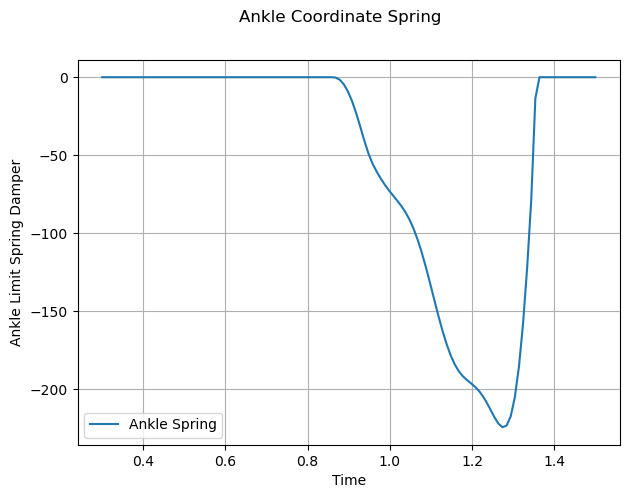

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Ankle Coordinate Spring')

# Plot the knee angles on the first subplot.
axs.plot(time_SO_Strong_RRA, ankle_limit_spring_damper.to_numpy(), label='Ankle Spring')
axs.set_xlabel('Time')
axs.set_ylabel('Ankle Limit Spring Damper')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Plot the Gastrocnemius activation from the analyzes with and without the Spring (the results should be in the folder `SO_Normal_RRA_Results` from Study 4 and the latest folder, `SO_Normal_RRA_Spring_Results`)

In [50]:
# Get results from file.
table_activation_SO_Normal_RRA_Spring = osim.TimeSeriesTable(
    "SO_Normal_RRA_Spring_Results/SO_Normal_RRA_Spring_StaticOptimization_activation.sto")

# Get values.
time_SO_Normal_RRA_Spring = table_activation_SO_Normal_RRA_Spring.getIndependentColumn()
gastrocnemius_muscle_activation_normal_rra_spring = table_activation_SO_Normal_RRA_Spring.getDependentColumn("gastroc_r")

# Get results from file.
table_activation_SO_Normal_RRA = osim.TimeSeriesTable(
    "SO_Normal_RRA_Results/SO_Normal_RRA_StaticOptimization_activation.sto")

# Get values.
time_SO_Normal_RRA = table_activation_SO_Normal_RRA.getIndependentColumn()
gastrocnemius_muscle_activation_normal_rra = table_activation_SO_Normal_RRA.getDependentColumn("gastroc_r")

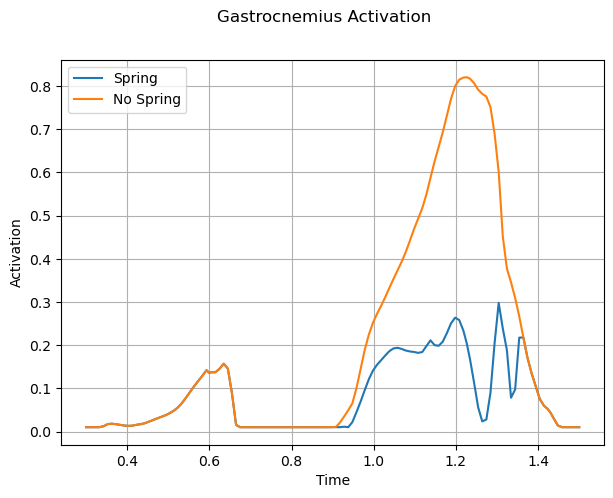

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Gastrocnemius Activation')

# Plot the knee angles on the first subplot.
axs.plot(time_SO_Normal_RRA, gastrocnemius_muscle_activation_normal_rra_spring.to_numpy(), label='Spring')
axs.plot(time_SO_Strong_RRA, gastrocnemius_muscle_activation_normal_rra.to_numpy(), label='No Spring')
axs.set_xlabel('Time')
axs.set_ylabel('Activation')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

**Questions**:

*  Why did the gastrocnemius activation decrease when the ankle spring was added?

*  Optional: try increasing or decreasing the spring stiffness. How does this affect the gastrocnemius activation? 

*  Optional: are any other muscles affected by adding the ankle spring?

## 6.7. Conclusion

In this tutorial you have learned how to perform a Static Optimization Analysis, to troubleshoot the different problems associated with it by filtering the motion, using RRA, and tuning the reserve and residual actuators. Also, you have learned to ann a passive element to your model and perform a Static Optimization analysis with it.

## 6.8. Useful Links





> **OpenSim Website:** https://opensim.stanford.edu/
>
> **OpenSim API Documentation:** https://simtk.org/api_docs/opensim/api_docs/
> 
> **OpenSim Creator Website:** https://opensimcreator.com/
> 
> **SimTK Website:** https://simtk.org/projects/opensim
> 
> **Biomechanics of Movement's Course:** https://www.youtube.com/channel/UCDNGy0KKNLQ-ztcL5h2Z6zA

##6.9 Acknowledgments

Thanks to [OpenSimColab](https://simtk.org/projects/opencolab) project [[3]](https://doi.org/10.1080/10255842.2022.2104607) for creating the first OpenSim Conda package.

## 6.10. References




> [1].   Delp, S. L., Anderson, F. C., Arnold, A. S., Loan, P., Habib, A., John, C. T., Guendelman, E., & Thelen, D. G. (2007). **OpenSim: open-source software to create and analyze dynamic simulations of movement.** *IEEE Transactions on Bio-Medical Engineering*, 54(11), 1940–1950. https://doi.org/10.1109/TBME.2007.901024
> 
> [2] Hicks, J. L., Uchida, T. K., Seth, A., Rajagopal, A., & Delp, S. L. (2015). **Is my model good enough? Best practices for verification and validation of musculoskeletal models and simulations of movement.** *Journal of Biomechanical Engineering*, 137(2), 020905. https://doi.org/10.1115/1.4029304
>
> [3] Mokhtarzadeh, H., Jiang, F., Zhao, S., & Malekipour, F. (2022). **OpenColab project: OpenSim in Google colaboratory to explore biomechanics on the web.** *Computer Methods in Biomechanics and Biomedical Engineering*, 1–9. https://doi.org/10.1080/10255842.2022.2104607